In [141]:
import pandas as pd 
import sklearn

In [142]:
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [143]:
df = pd.read_csv("loan_data_final.csv")
df.head()

,Unnamed: 0,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_to_income_ratio,loan_type,dependents_count,regional_unemployment_rate,borrower_risk_score,loan_status
0,0,22,female,Master,71948,0,RENT,PERSONAL,16.02,0.49,3,561,No,0.49,FLOATING,3,6.84,281.4,1
1,1,21,female,High School,12282,0,OWN,EDUCATION,11.14,0.08,2,504,Yes,0.08,FIXED,0,5.96,252.4,0
2,2,25,female,High School,12438,3,MORTGAGE,MEDICAL,12.87,0.44,3,635,No,0.44,FIXED,0,6.69,318.4,1
3,3,23,female,Bachelor,79753,0,RENT,MEDICAL,15.23,0.44,2,675,No,0.44,FIXED,3,7.63,338.1,1
4,4,24,male,Master,66135,1,RENT,MEDICAL,14.27,0.53,4,586,No,0.53,FLOATING,0,4.63,294.2,1


From this short view of the data, it's clear that we should be modeling for the borrower_risk_score from all these factors such as their previous defaults, income, number of dependents, etc. Since we have so many factors, some numerical and some categorical, using a tree regression would be a good approach.

In [144]:
print(len(df))
df = df.dropna()
print(len(df))

45000
45000


In [145]:
import numpy as np
df_new = df
df_new["gender"] = pd.Series([0 if i=="female" else 1 for i in df["person_gender"]])
df_new["loan_type"] = pd.Series([0 if i=="FLOATING" else 1 for i in df["loan_type"]])
df_new["prev_default"] = pd.Series([0 if i=="No" else 1 for i in df["previous_loan_defaults_on_file"]])

In [146]:
unique_education = set()
for i in df["person_education"]:
    unique_education.add(i)
print(unique_education)
education_score = dict()
for i in unique_education:
    if i=="High School":
        j = 1
    if i=="Associate":
        j = 2
    if i=="Bachelor":
        j = 3
    if i=="Master":
        j = 4
    else:
        j = 5
    education_score[i] = j
df_new["education"] = pd.Series([education_score[i] for i in df["person_education"]])

{'Associate', 'Master', 'Bachelor', 'High School', 'Doctorate'}


In [147]:
unique_home = set()
for i in df["person_home_ownership"]:
    unique_home.add(i)
print(unique_home)
home_score = dict()
for i in unique_home:
    if i=="RENT":
        j = 1
    if i=="MORTGAGE":
        j = 2
    if i=="OWN":
        j = 3
    else:
        j = 0
    home_score[i] = j
df_new["home"] = pd.Series([home_score[i] for i in df["person_home_ownership"]])

{'RENT', 'MORTGAGE', 'OTHER', 'OWN'}


In [148]:
unique_intent = set()
for i in df["loan_intent"]:
    unique_intent.add(i)
print(unique_intent)
intent_score = dict()
for i in unique_intent:
    if i=="MEDICAL":
        j = 1
    if i=="HOMEIMPROVEMENT":
        j = 2
    if i=="EDUCATION":
        j = 3
    if i=="VENTURE":
        j = 4
    if i=="PERSONAL":
        j = 5
    else:
        j = 6
    intent_score[i] = j
df_new["intent"] = pd.Series([intent_score[i] for i in df["loan_intent"]])

{'MEDICAL', 'HOMEIMPROVEMENT', 'EDUCATION', 'VENTURE', 'PERSONAL', 'DEBTCONSOLIDATION'}


In [149]:
df_new

,Unnamed: 0,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_intent,loan_int_rate,loan_percent_income,...,loan_type,dependents_count,regional_unemployment_rate,borrower_risk_score,loan_status,gender,prev_default,education,home,intent
0,0,22,female,Master,71948,0,RENT,PERSONAL,16.02,0.49,...,0,3,6.84,281.4,1,0,0,4,0,5
1,1,21,female,High School,12282,0,OWN,EDUCATION,11.14,0.08,...,1,0,5.96,252.4,0,0,1,5,3,6
2,2,25,female,High School,12438,3,MORTGAGE,MEDICAL,12.87,0.44,...,1,0,6.69,318.4,1,0,0,5,0,6
3,3,23,female,Bachelor,79753,0,RENT,MEDICAL,15.23,0.44,...,1,3,7.63,338.1,1,0,0,5,0,6
4,4,24,male,Master,66135,1,RENT,MEDICAL,14.27,0.53,...,0,0,4.63,294.2,1,1,0,4,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,44995,27,male,Associate,47971,6,RENT,MEDICAL,15.66,0.31,...,1,0,6.53,323.4,1,1,0,5,0,6
44996,44996,37,female,Associate,65800,17,RENT,HOMEIMPROVEMENT,14.07,0.14,...,1,2,4.33,313.8,1,0,0,5,0,6
44997,44997,33,male,Associate,56942,7,RENT,DEBTCONSOLIDATION,10.02,0.05,...,0,0,6.66,337.0,1,1,0,5,0,6
44998,44998,29,male,Bachelor,33164,4,RENT,EDUCATION,13.23,0.36,...,1,0,6.80,303.8,1,1,0,5,0,6


Let's start with some features I hand picked, which are what looks to be the most relavent to the risk score

In [150]:
df_simple_tree = df_new[["credit_score","person_income","intent","loan_int_rate","loan_percent_income","loan_type","regional_unemployment_rate","loan_status","prev_default","home"]]
df_simple_tree

,credit_score,person_income,intent,loan_int_rate,loan_percent_income,loan_type,regional_unemployment_rate,loan_status,prev_default,home
0,561,71948,5,16.02,0.49,0,6.84,1,0,0
1,504,12282,6,11.14,0.08,1,5.96,0,1,3
2,635,12438,6,12.87,0.44,1,6.69,1,0,0
3,675,79753,6,15.23,0.44,1,7.63,1,0,0
4,586,66135,6,14.27,0.53,0,4.63,1,0,0
...,...,...,...,...,...,...,...,...,...,...
44995,645,47971,6,15.66,0.31,1,6.53,1,0,0
44996,621,65800,6,14.07,0.14,1,4.33,1,0,0
44997,668,56942,6,10.02,0.05,0,6.66,1,0,0
44998,604,33164,6,13.23,0.36,1,6.80,1,0,0


In [151]:
np.random.seed(42)
X_train, X_test, Y_train, Y_test = train_test_split(df_simple_tree,df["borrower_risk_score"],test_size = 0.3, random_state = 42)
regressor = DecisionTreeRegressor(max_depth=7, random_state = 42)
regressor.fit(X_train,Y_train)

DecisionTreeRegressor(max_depth=7, random_state=42)

In [152]:
Y_pred = regressor.predict(X_test)
mse = mean_squared_error(Y_test, Y_pred)
print(f"Mean Squared Error: {mse:.4f}")

Mean Squared Error: 1.4635


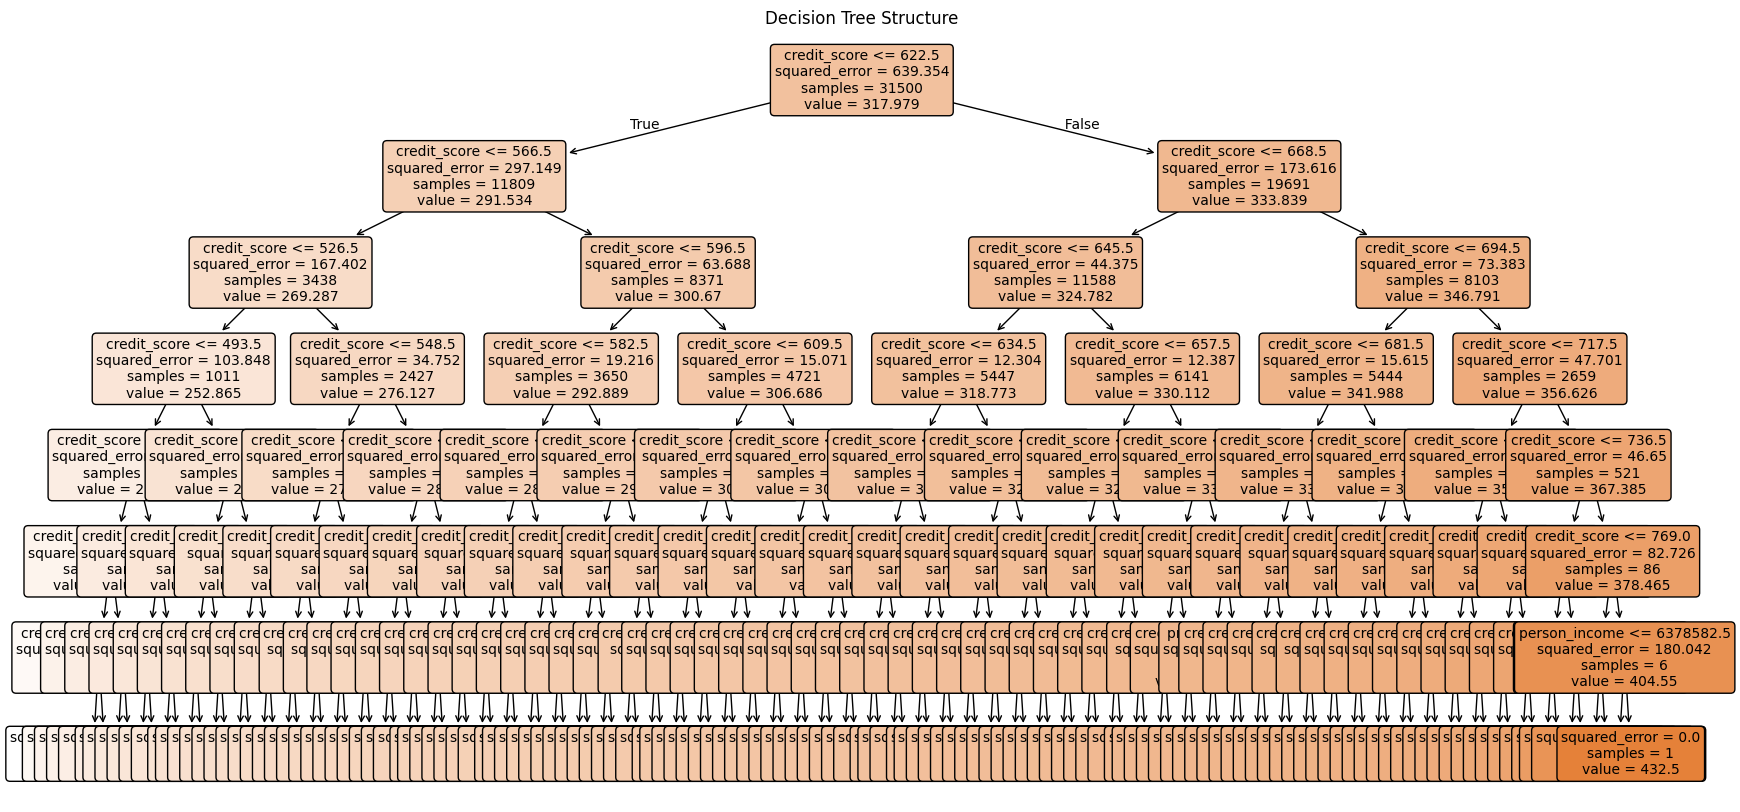

In [153]:
from sklearn.tree import plot_tree
from matplotlib import pyplot as plt

# Visualizing decision tree
plt.figure(figsize=(20, 10))
plot_tree(
    regressor,
    feature_names=["credit_score","person_income","intent","loan_int_rate","loan_percent_income","loan_type","regional_unemployment_rate","loan_status","prev_default","home"],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree Structure")
plt.show()

The performance doesn't look terrible, but we should check with a benchmark to actually understand its performance. Here, I used linear regression with the two most commonly-split-on features, credit_score and person_income

In [154]:
from sklearn.linear_model import LinearRegression
np.random.seed(42)
Y = np.array(df["borrower_risk_score"])
X = np.array(df[["credit_score","person_income"]])
X_train_slr, X_test_slr, Y_train_slr, Y_test_slr = train_test_split(X,Y,test_size=0.3,random_state=42)
model = LinearRegression()
model.fit(X_train_slr,Y_train_slr)
Y_pred_slr = model.predict(X_test_slr)
mse_slr = mean_squared_error(Y_test_slr,Y_pred_slr)
print(mse_slr)

1.343073810530328


As we can see, simple linear regression actually managed to beat our tree regression, so we might need some adjustments. First, I want to check how well the model can do with all the features, including the ones I discarded.

In [155]:
df_new = df_new.drop(["previous_loan_defaults_on_file","person_gender","person_education","person_home_ownership","loan_intent"],axis=1)
df_new = df_new.rename(columns={"borrower_risk_score":"risk_score"})
df_new

,Unnamed: 0,person_age,person_income,person_emp_exp,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_to_income_ratio,loan_type,dependents_count,regional_unemployment_rate,risk_score,loan_status,gender,prev_default,education,home,intent
0,0,22,71948,0,16.02,0.49,3,561,0.49,0,3,6.84,281.4,1,0,0,4,0,5
1,1,21,12282,0,11.14,0.08,2,504,0.08,1,0,5.96,252.4,0,0,1,5,3,6
2,2,25,12438,3,12.87,0.44,3,635,0.44,1,0,6.69,318.4,1,0,0,5,0,6
3,3,23,79753,0,15.23,0.44,2,675,0.44,1,3,7.63,338.1,1,0,0,5,0,6
4,4,24,66135,1,14.27,0.53,4,586,0.53,0,0,4.63,294.2,1,1,0,4,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,44995,27,47971,6,15.66,0.31,3,645,0.31,1,0,6.53,323.4,1,1,0,5,0,6
44996,44996,37,65800,17,14.07,0.14,11,621,0.14,1,2,4.33,313.8,1,0,0,5,0,6
44997,44997,33,56942,7,10.02,0.05,10,668,0.05,0,0,6.66,337.0,1,1,0,5,0,6
44998,44998,29,33164,4,13.23,0.36,6,604,0.36,1,0,6.80,303.8,1,1,0,5,0,6


In [166]:
np.random.seed(42)
X_train_new, X_test_new, Y_train_new, Y_test_new = train_test_split(df_new.drop(columns="risk_score",axis=1),df["borrower_risk_score"],test_size = 0.3, random_state = 42)
regressor = DecisionTreeRegressor(max_depth=10, random_state = 42)
regressor.fit(X_train_new,Y_train_new)
Y_pred_new = regressor.predict(X_test_new)
mse = mean_squared_error(Y_test_new, Y_pred_new)
print(f"Mean Squared Error: {mse:.4f}")

Mean Squared Error: 0.1699


In [168]:
list_features = []
for i in df_new.columns:
    list_features.append(i)
print(list_features[1:])

['person_age', 'person_income', 'person_emp_exp', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score', 'loan_to_income_ratio', 'loan_type', 'dependents_count', 'regional_unemployment_rate', 'risk_score', 'loan_status', 'gender', 'prev_default', 'education', 'home', 'intent']


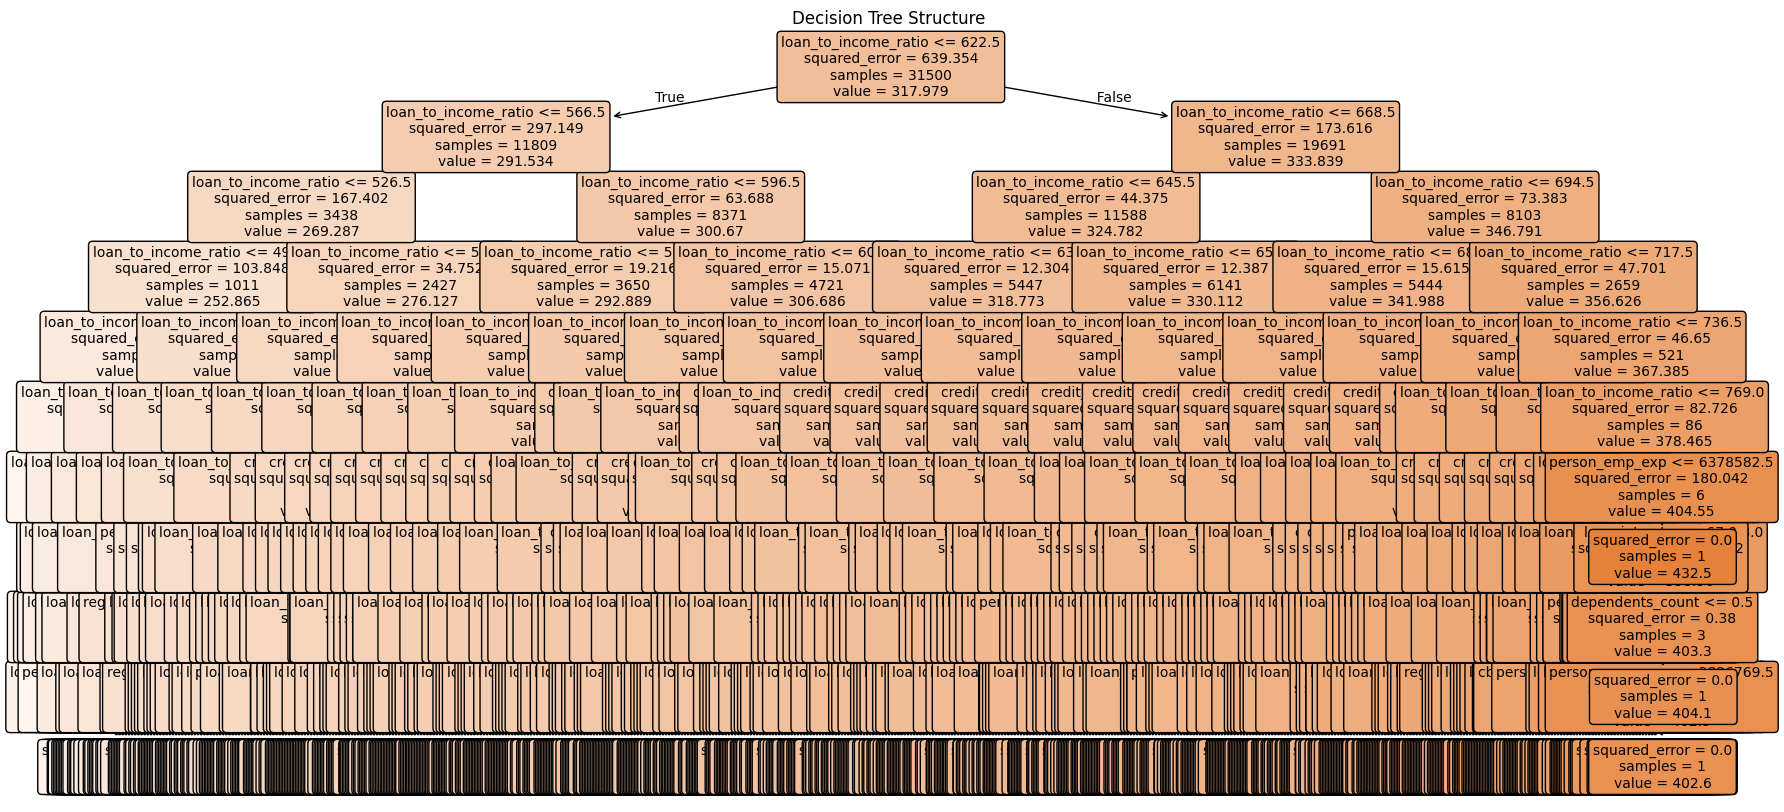

In [169]:
# Visualizing decision tree
plt.figure(figsize=(20, 10))
plot_tree(
    regressor,
    feature_names=['person_age', 'person_income', 'person_emp_exp', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score', 'loan_to_income_ratio', 'loan_type', 'dependents_count', 'regional_unemployment_rate', 'risk_score', 'loan_status', 'gender', 'prev_default', 'education', 'home', 'intent'],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree Structure")
plt.show()

While the MSE looks better, this can suffer from overfitting, and I do not have enough time to test that. Instead, I will try a different approach: a Lasso regression, punishing overfitting and performing feature selection for me. 

In [182]:
from sklearn.linear_model import Lasso
np.random.seed(42)
Y = np.array(df["borrower_risk_score"])
X_lasso = np.array(df[['person_age', 'person_income', 'person_emp_exp', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score', 'loan_to_income_ratio', 'loan_type', 'dependents_count', 'regional_unemployment_rate', 'loan_status', 'gender', 'prev_default', 'education', 'home', 'intent']])
X_train_lasso, X_test_lasso, Y_train_lasso, Y_test_lasso = train_test_split(X_lasso,Y,test_size=0.3,random_state=42)
model = Lasso()
model.fit(X_train_lasso,Y_train_lasso)
Y_pred_lasso = model.predict(X_test_lasso)
mse_lasso = mean_squared_error(Y_test_lasso,Y_pred_lasso)
print(mse_lasso)

0.09391781813319003


In [184]:
print(model.intercept_)
print(model.coef_)

-0.7820131286801484
[ 3.71119557e-02  4.68192560e-08  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.82307064e-01  5.00530114e-01  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00]


The lasso regression actually managed to do very well, and here we can see the features that remained from the selection process. Let's test this on a tree regression.

In [185]:
df_final_tree = df_new[["person_age","person_income","cb_person_cred_hist_length","credit_score"]]
df_final_tree

,person_age,person_income,cb_person_cred_hist_length,credit_score
0,22,71948,3,561
1,21,12282,2,504
2,25,12438,3,635
3,23,79753,2,675
4,24,66135,4,586
...,...,...,...,...
44995,27,47971,3,645
44996,37,65800,11,621
44997,33,56942,10,668
44998,29,33164,6,604


In [195]:
np.random.seed(42)
X_train_f, X_test_f, Y_train_f, Y_test_f = train_test_split(df_final_tree,df["borrower_risk_score"],test_size = 0.3, random_state = 42)
regressor = DecisionTreeRegressor(max_depth=7, random_state = 42)
regressor.fit(X_train_f,Y_train_f)

DecisionTreeRegressor(max_depth=7, random_state=42)

In [197]:
Y_pred_f = regressor.predict(X_test_f)
mse = mean_squared_error(Y_test_f, Y_pred_f)
print(f"Mean Squared Error: {mse:.4f}")

Mean Squared Error: 0.7928


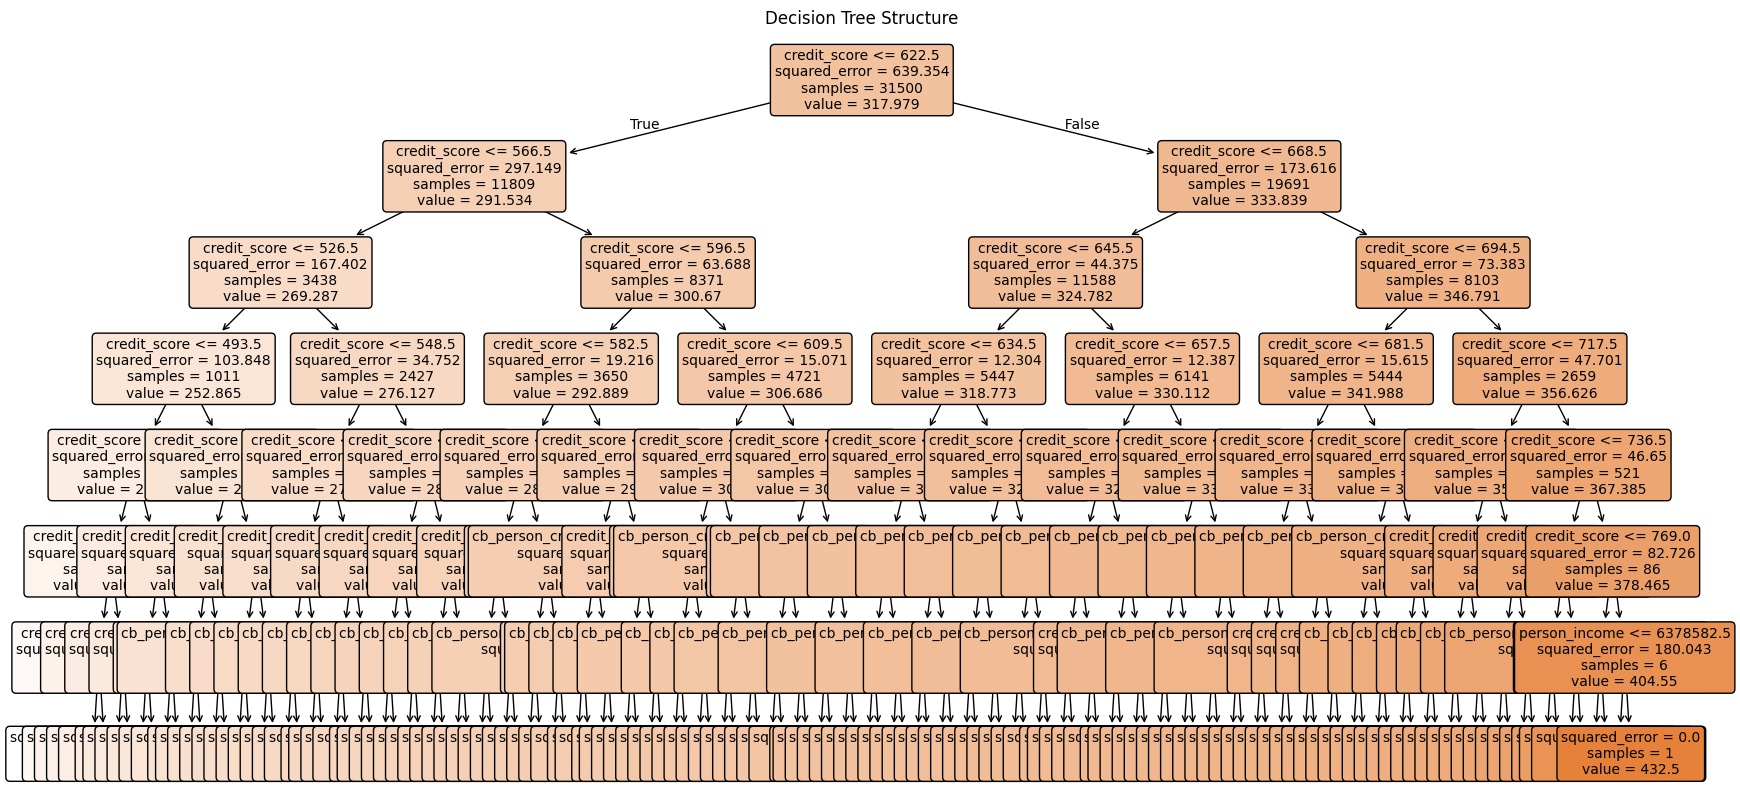

In [198]:
# Visualizing decision tree
plt.figure(figsize=(20, 10))
plot_tree(
    regressor,
    feature_names=["person_age","person_income","cb_person_cred_hist_length","credit_score"],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree Structure")
plt.show()

While the performance of the tree regression certainly improved, it did not reach the performance of the lasso regression, and without enough time to check for overfitting and optimize simulation depth, I think we could stick with the lasso regression for now.